# Traditional Augmentation
- In this notebook, we will be applying a data-centric approach on our baseline model. We will be using Traditional Augmentation techniques, such as Center Crop, Rotate, Color Shift, Flip, etc in this kernel.
- We will be applying these techniques in 3 different ways. Firstly, we will apply these techniques on 25% of the samples from the training dataset irrespective of their classes, and then observe the accuracy of the baseline model after training it on the augmented dataset.
- Secondly, we will be using these techniques for class balancing, and then, will train the baseline model on the balanced dataset.
- Thirdly, we will be analysing the class-wise performance of the baseline model, and will apply augmentation on only those classes on which the baseline model is not performing well.

# 1. Importing the Packages & Boilerplate Code

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from shutil import copyfile
from tabulate import tabulate
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import tensorflow.keras.layers as tfl

In [2]:
# Setting the seeds
SEED = 0
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Making sure that Tensorflow is able to detect the GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Defining a function to list the memory consumed
# Only outputs variables taking at least 1MB space
def list_storage(inp_dir):
    # Get a sorted list of the objects and their sizes
    vars_defined = [x for x in inp_dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    sto = sorted([(x, sys.getsizeof(globals().get(x))) for x in vars_defined], key=lambda x: x[1], reverse=True)
    sto = [(x[0], str(round((x[1] / 2**20), 2)) + ' MB') for x in sto if x[1] >= 2**20]
    print(tabulate(sto, headers = ['Variable', 'Storage (in MB)']))

# In order to use this function, use the below line of code
# list_storage(dir())

# 2. Importing the Train/Test Sets

In [5]:
# Importing the Labelled Dataset
df_train = pd.read_csv("../input/cifar10/train_lab_x.csv")
y_train = pd.read_csv("../input/cifar10/train_lab_y.csv")
df_train = np.array(df_train)
y_train = np.array(y_train)
print(df_train.shape, y_train.shape)

# Reshaping the dataset
df_train = np.reshape(df_train, (-1, 3, 32, 32))
print(df_train.shape)

# Basic Pre-processing
# Creating a random permutation
perm = np.random.permutation(df_train.shape[0])

# Shuffling the training dataset
df_train = df_train[perm, : , : , : ]
y_train = y_train[perm]

# Reshaping, rescaling and one-hot encoding
df_train = np.transpose(np.array(df_train), (0, 2, 3, 1))
df_train = df_train / 255
y_train_oh = tf.one_hot(np.ravel(y_train), depth = 10)
print(df_train.shape, y_train_oh.shape)

# Importing the Test Dataset
df_test = pd.read_csv("../input/cifar10/test_x.csv")
y_test = pd.read_csv("../input/cifar10/test_y.csv")
df_test = np.array(df_test)
y_test = np.array(y_test)
print(df_test.shape, y_test.shape)

# Reshaping the dataset
df_test = np.reshape(df_test, (-1, 3, 32, 32))
print(df_test.shape)

# Reshaping, rescaling and one-hot encoding
df_test = np.transpose(np.array(df_test), (0, 2, 3, 1))
df_test = df_test / 255
y_test_oh = tf.one_hot(np.ravel(y_test), depth = 10)
print(df_test.shape, y_test_oh.shape)

(40006, 3072) (40006, 1)
(40006, 3, 32, 32)
(40006, 32, 32, 3) (40006, 10)
(10000, 3072) (10000, 1)
(10000, 3, 32, 32)
(10000, 32, 32, 3) (10000, 10)


# 3. Defining the Tensorflow Augmentations

In [6]:
data_augmentation = tf.keras.Sequential([
    tfl.RandomFlip("horizontal"),
    tfl.RandomRotation(0.1),
])

# 4. Image Augmentation on 25% of the Training Dataset
## 4.1. Augmenting the Training Dataset

(32, 32, 3)
(1, 32, 32, 3)


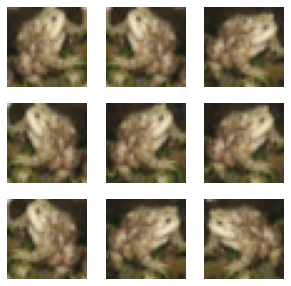

In [7]:
# Visualizing a single image
ind = 16
example = df_train[ind, : , : , : ]
print(example.shape)

# Add the image to a batch.
image = tf.cast(tf.expand_dims(example, 0), tf.float32)
print(image.shape)

plt.figure(figsize=(5, 5))
for i in range(9):
    aug_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(aug_image[0])
    plt.axis("off")

In [8]:
# Creating an empty list
df_train_aug, y_train_aug = [], []

# Iterating over all the images in the dataset
for ind in tqdm(range(df_train.shape[0])):
    if np.random.uniform() <= 0.25:
        aug_image = data_augmentation(df_train[ind, : , : , : ])
        df_train_aug.append(aug_image)
        y_train_aug.append(y_train[ind])

# Sanity Checks and Transformations
df_train_aug = np.array(df_train_aug)
y_train_aug = np.reshape(np.array(y_train_aug), (-1, 1))
y_train_aug_oh = tf.one_hot(np.ravel(y_train_aug), depth = 10)
print(df_train_aug.shape, y_train_aug.shape, y_train_aug_oh.shape)

df_aug = np.concatenate([df_train, df_train_aug], axis = 0)
y_aug = np.concatenate([y_train, y_train_aug], axis = 0)
y_aug_oh = np.concatenate([y_train_oh, y_train_aug_oh], axis = 0)
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

# Creating a random permutation
perm_aug = np.random.permutation(df_aug.shape[0])

# Shuffling the augmented dataset
df_aug = df_aug[perm_aug, : , : , : ]
y_aug = y_aug[perm_aug]
y_aug_oh = y_aug_oh[perm_aug, : ]
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

100%|██████████| 40006/40006 [01:16<00:00, 521.87it/s]


(10045, 32, 32, 3) (10045, 1) (10045, 10)
(50051, 32, 32, 3) (50051, 1) (50051, 10)
(50051, 32, 32, 3) (50051, 1) (50051, 10)


## 4.2. Training the Baseline Model on the Augmented Dataset

In [9]:
# Importing the Baseline Model Architecture
copyfile(src = "../input/dcai-rw/baseline_arch.py", dst = "../working/baseline_arch.py")
from baseline_arch import cnn_model

# Creating Batches from the Augmented Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((df_aug, y_aug_oh)).batch(32)

In [10]:
num_epochs = [10, 20, 30, 40, 50]
train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epochs in num_epochs:
    # Training the Model
    conv_model = cnn_model((32, 32, 3))
    conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    conv_model.fit(train_dataset, epochs = epochs)
    
    # Predicting on the Train/Test Datasets
    preds_train = conv_model.predict(df_aug)
    preds_test = conv_model.predict(df_test)

    # Finding the Predicted Classes
    cls_train = np.argmax(preds_train, axis = 1)
    cls_test = np.argmax(preds_test, axis = 1)
    
    # Finding the Train/Test set Loss
    train_loss.append(log_loss(y_aug_oh, preds_train))
    test_loss.append(log_loss(y_test_oh, preds_test))
    train_acc.append(accuracy_score(y_aug, cls_train))
    test_acc.append(accuracy_score(y_test, cls_test))
    
    print("For ", epochs, " Epochs:")
    print("Log-loss for Train Dataset = ", train_loss[-1])
    print("Log-loss for Test Dataset = ", test_loss[-1])
    print("Accuracy for Train Dataset = ", train_acc[-1])
    print("Accuracy for Test Dataset = ", test_acc[-1])
    print()

Epoch 1/10
1565/1565 [==============================] - 15s 5ms/step - loss: 1.7245 - accuracy: 0.3754
Epoch 2/10
1565/1565 [==============================] - 7s 5ms/step - loss: 1.3279 - accuracy: 0.5303
Epoch 3/10
1565/1565 [==============================] - 8s 5ms/step - loss: 1.1664 - accuracy: 0.5928
Epoch 4/10
1565/1565 [==============================] - 8s 5ms/step - loss: 1.0590 - accuracy: 0.6338
Epoch 5/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.9774 - accuracy: 0.6633
Epoch 6/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.9193 - accuracy: 0.6827
Epoch 7/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.8716 - accuracy: 0.7002
Epoch 8/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.8242 - accuracy: 0.7146
Epoch 9/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.7924 - accuracy: 0.7273
Epoch 10/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.76

In [11]:
# Training the Model with the best hyper-parameter settings
ind = np.argmax(test_acc)
best_num_epochs = num_epochs[ind]
conv_model = cnn_model((32, 32, 3))
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
conv_model.fit(train_dataset, epochs = best_num_epochs)

# Saving the model along with it's weights
conv_model.save('trad_augmented_all.h5')

Epoch 1/50
1565/1565 [==============================] - 8s 5ms/step - loss: 1.7025 - accuracy: 0.3845
Epoch 2/50
1565/1565 [==============================] - 8s 5ms/step - loss: 1.3132 - accuracy: 0.5362
Epoch 3/50
1565/1565 [==============================] - 8s 5ms/step - loss: 1.1550 - accuracy: 0.5984
Epoch 4/50
1565/1565 [==============================] - 8s 5ms/step - loss: 1.0566 - accuracy: 0.6382
Epoch 5/50
1565/1565 [==============================] - 7s 5ms/step - loss: 0.9782 - accuracy: 0.6613
Epoch 6/50
1565/1565 [==============================] - 7s 5ms/step - loss: 0.9162 - accuracy: 0.6852
Epoch 7/50
1565/1565 [==============================] - 7s 5ms/step - loss: 0.8728 - accuracy: 0.7002
Epoch 8/50
1565/1565 [==============================] - 8s 5ms/step - loss: 0.8389 - accuracy: 0.7111
Epoch 9/50
1565/1565 [==============================] - 7s 5ms/step - loss: 0.8022 - accuracy: 0.7231
Epoch 10/50
1565/1565 [==============================] - 8s 5ms/step - loss: 0.763

## 4.3. Predicting the Performance

In [12]:
# Predicting on the Train/Test Datasets
preds_train = conv_model.predict(df_aug)
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_aug_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Train Dataset = ", accuracy_score(y_aug, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.12611151136584786
Log-loss for Test Dataset =  0.7620186091606302
Accuracy for Train Dataset =  0.9634572735809475
Accuracy for Test Dataset =  0.774


# 5. Image Augmentation for Class Balancing
## 5.1. Finding out the Class Imbalance

In [13]:
y_train_reshape = np.reshape(y_train, (-1))
num_examples = np.zeros((10,))

for i in y_train_reshape:
    num_examples[i] += 1

# Number of examples from each class
num_exa = num_examples.astype('int32')

# Finding out the maximum number of examples for any class
max_exa = max(num_exa)

# Number of examples that needs to be added to each of the classes
aug_exa = [max_exa - num_exa[i] for i in range(10)]

# Creating a list of lists for storing the indices of data-points in the training dataset, class-wise
classes_ind = []
for i in range(10):
    classes_ind.append([])

for ind, clss in enumerate(y_train_reshape):
    classes_ind[clss].append(ind)

# # Transforming list of lists into numpy array
# classes_ind = np.array([np.array(xi) for xi in classes_ind])

print(num_exa)
print(aug_exa, sum(aug_exa))
print(len(classes_ind), len(classes_ind[0]))

# Creating a list for indices of images and their labels on which augmentation needs to be done
# These are randomly chosen from each class
aug_ind = []
y_train_aug = []

for i in range(10):
    indices = random.choices(classes_ind[i], k = aug_exa[i])
    aug_ind.extend(indices)
    y_train_aug.extend([i]*aug_exa[i])

print(len(aug_ind), len(y_train_aug))

[4109 3839 4022 4116 4312 3952 4290 3552 3436 4378]
[269, 539, 356, 262, 66, 426, 88, 826, 942, 0] 3774
10 4109
3774 3774


## 5.2. Augmenting based on the Class Imbalance

In [14]:
# Creating an empty list
df_train_aug = []

for ind in tqdm(aug_ind):
    aug_image = data_augmentation(df_train[ind, : , : , : ])
    df_train_aug.append(aug_image)
    
# Sanity Checks and Transformations
df_train_aug = np.array(df_train_aug)
y_train_aug = np.reshape(np.array(y_train_aug), (-1, 1))
y_train_aug_oh = tf.one_hot(np.ravel(y_train_aug), depth = 10)
print(df_train_aug.shape, y_train_aug.shape, y_train_aug_oh.shape)

df_aug = np.concatenate([df_train, df_train_aug], axis = 0)
y_aug = np.concatenate([y_train, y_train_aug], axis = 0)
y_aug_oh = np.concatenate([y_train_oh, y_train_aug_oh], axis = 0)
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

# Creating a random permutation
perm_aug = np.random.permutation(df_aug.shape[0])

# Shuffling the augmented dataset
df_aug = df_aug[perm_aug, : , : , : ]
y_aug = y_aug[perm_aug]
y_aug_oh = y_aug_oh[perm_aug, : ]
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

100%|██████████| 3774/3774 [00:29<00:00, 126.73it/s]


(3774, 32, 32, 3) (3774, 1) (3774, 10)
(43780, 32, 32, 3) (43780, 1) (43780, 10)
(43780, 32, 32, 3) (43780, 1) (43780, 10)


In [15]:
# Finding out the number of examples in each class after augmentation
num_examples = np.zeros((10,))
for i in y_aug[:]:
    num_examples[i[0]] += 1
print(num_examples)

[4378. 4378. 4378. 4378. 4378. 4378. 4378. 4378. 4378. 4378.]


## 5.3. Training the Baseline Model on the Augmented Dataset

In [16]:
# Importing the Baseline Model Architecture
copyfile(src = "../input/dcai-rw/baseline_arch.py", dst = "../working/baseline_arch.py")
from baseline_arch import cnn_model

# Creating Batches from the Augmented Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((df_aug, y_aug_oh)).batch(32)

In [17]:
num_epochs = [10, 20, 30, 40, 50]
train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epochs in num_epochs:
    # Training the Model
    conv_model = cnn_model((32, 32, 3))
    conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    conv_model.fit(train_dataset, epochs = epochs)
    
    # Predicting on the Train/Test Datasets
    preds_train = conv_model.predict(df_aug)
    preds_test = conv_model.predict(df_test)

    # Finding the Predicted Classes
    cls_train = np.argmax(preds_train, axis = 1)
    cls_test = np.argmax(preds_test, axis = 1)
    
    # Finding the Train/Test set Loss
    train_loss.append(log_loss(y_aug_oh, preds_train))
    test_loss.append(log_loss(y_test_oh, preds_test))
    train_acc.append(accuracy_score(y_aug, cls_train))
    test_acc.append(accuracy_score(y_test, cls_test))
    
    print("For ", epochs, " Epochs:")
    print("Log-loss for Train Dataset = ", train_loss[-1])
    print("Log-loss for Test Dataset = ", test_loss[-1])
    print("Accuracy for Train Dataset = ", train_acc[-1])
    print("Accuracy for Test Dataset = ", test_acc[-1])
    print()

Epoch 1/10
1369/1369 [==============================] - 7s 5ms/step - loss: 1.7073 - accuracy: 0.3844
Epoch 2/10
1369/1369 [==============================] - 6s 5ms/step - loss: 1.3527 - accuracy: 0.5209
Epoch 3/10
1369/1369 [==============================] - 7s 5ms/step - loss: 1.1742 - accuracy: 0.5913
Epoch 4/10
1369/1369 [==============================] - 7s 5ms/step - loss: 1.0411 - accuracy: 0.6407
Epoch 5/10
1369/1369 [==============================] - 6s 5ms/step - loss: 0.9683 - accuracy: 0.6669
Epoch 6/10
1369/1369 [==============================] - 7s 5ms/step - loss: 0.9075 - accuracy: 0.6891
Epoch 7/10
1369/1369 [==============================] - 6s 5ms/step - loss: 0.8560 - accuracy: 0.7059
Epoch 8/10
1369/1369 [==============================] - 7s 5ms/step - loss: 0.8095 - accuracy: 0.7205
Epoch 9/10
1369/1369 [==============================] - 7s 5ms/step - loss: 0.7737 - accuracy: 0.7355
Epoch 10/10
1369/1369 [==============================] - 7s 5ms/step - loss: 0.737

In [18]:
# Training the Model with the best hyper-parameter settings
ind = np.argmax(test_acc)
best_num_epochs = num_epochs[ind]
conv_model = cnn_model((32, 32, 3))
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
conv_model.fit(train_dataset, epochs = best_num_epochs)

# Saving the model along with it's weights
conv_model.save('trad_augmented_cls_imbalance.h5')

Epoch 1/50
1369/1369 [==============================] - 8s 5ms/step - loss: 1.7472 - accuracy: 0.3667
Epoch 2/50
1369/1369 [==============================] - 7s 5ms/step - loss: 1.3544 - accuracy: 0.5227
Epoch 3/50
1369/1369 [==============================] - 6s 5ms/step - loss: 1.1848 - accuracy: 0.5888
Epoch 4/50
1369/1369 [==============================] - 6s 5ms/step - loss: 1.0626 - accuracy: 0.6318
Epoch 5/50
1369/1369 [==============================] - 7s 5ms/step - loss: 0.9754 - accuracy: 0.6665
Epoch 6/50
1369/1369 [==============================] - 7s 5ms/step - loss: 0.9081 - accuracy: 0.6883
Epoch 7/50
1369/1369 [==============================] - 6s 5ms/step - loss: 0.8579 - accuracy: 0.7071
Epoch 8/50
1369/1369 [==============================] - 6s 5ms/step - loss: 0.8182 - accuracy: 0.7187
Epoch 9/50
1369/1369 [==============================] - 6s 5ms/step - loss: 0.7826 - accuracy: 0.7323
Epoch 10/50
1369/1369 [==============================] - 6s 5ms/step - loss: 0.747

## 5.4. Predicting the Performance

In [19]:
# Predicting on the Train/Test Datasets
preds_train = conv_model.predict(df_aug)
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_aug_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Train Dataset = ", accuracy_score(y_aug, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.09333135296612383
Log-loss for Test Dataset =  0.8160191787884823
Accuracy for Train Dataset =  0.9733668341708542
Accuracy for Test Dataset =  0.7746


# 6. Image Augmentation based on Class-wise Performance
## 6.1. Finding out the Class-wise Performance of the Baseline Model

In [20]:
# Importing the Baseline Model
conv_model = tf.keras.models.load_model("../input/dcai-rw/baseline_model.h5")

# Predicting on the Test Datasets
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_test = np.argmax(preds_test, axis = 1)

# Finding the Test set Loss
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Test Dataset =  0.7801565846856381
Accuracy for Test Dataset =  0.7822


In [21]:
# Creating a list of lists for storing the class-wise indices of the Test Dataset
indices = []
for _ in range(10):
    indices.append([])
for ind, y in enumerate(y_test):
    indices[y[0]].append(ind)

# Creating list of lists values
y_test_cls = []
y_test_oh_cls = []
preds_test_cls = []
cls_test_cls = []

for _ in range(10):
    y_test_cls.append([])
    y_test_oh_cls.append([])
    preds_test_cls.append([])
    cls_test_cls.append([])

for ind, y in enumerate(y_test):
    label = y[0]
    y_test_cls[label].append(y_test[ind])
    y_test_oh_cls[label].append(y_test_oh[ind])
    preds_test_cls[label].append(preds_test[ind])
    cls_test_cls[label].append(cls_test[ind])

# Sanity Checks
print(len(y_test_cls), len(y_test_oh_cls), len(preds_test_cls), len(cls_test_cls))
print(len(y_test_cls[4]), len(y_test_oh_cls[3]), len(preds_test_cls[2]), len(cls_test_cls[1]))
print(len(y_test_oh_cls[3][42]), len(y_test_oh_cls[5][49]))
print()

# Finding the Class-Wise Log-loss and Accuracy on the Test Set
cls_wise_acc = []
for i in range(10):
    acc = accuracy_score(y_test_cls[i], cls_test_cls[i])
    cls_wise_acc.append(acc)
    print('For Class ', i)
    print("Log-loss = ", log_loss(y_test_oh_cls[i], preds_test_cls[i]))
    print("Accuracy = ", acc)
    print()

10 10 10 10
1000 1000 1000 1000
10 10

For Class  0
Log-loss =  0.6607034056639866
Accuracy =  0.823

For Class  1
Log-loss =  0.45725158366243285
Accuracy =  0.876

For Class  2
Log-loss =  1.2545300613705768
Accuracy =  0.663

For Class  3
Log-loss =  1.5699013437419735
Accuracy =  0.538

For Class  4
Log-loss =  0.7724096510888028
Accuracy =  0.776

For Class  5
Log-loss =  0.8724455790499097
Accuracy =  0.729

For Class  6
Log-loss =  0.42640308126623816
Accuracy =  0.885

For Class  7
Log-loss =  0.8416897772332993
Accuracy =  0.766

For Class  8
Log-loss =  0.5221985497706122
Accuracy =  0.873

For Class  9
Log-loss =  0.42403281400854825
Accuracy =  0.893



## 6.2. Augmenting the Train Dataset

In [22]:
# Creating a list of lists for storing the indices of data-points in the training dataset, class-wise
classes_ind = []
y_train_reshape = np.reshape(y_train, (-1))
for i in range(10):
    classes_ind.append([])
for ind, clss in enumerate(y_train_reshape):
    classes_ind[clss].append(ind)
    
# Creating a list for indices of images and their labels on which augmentation needs to be done
# These are randomly chosen from each of the underperforming classes
aug_ind = []
y_train_aug = []

# As for the under-performing classes, we will simply be choosing those classes having accuracy
# less than 80%
und_cls = [ind for ind, val in enumerate(cls_wise_acc) if val < 0.80]
print("Under-performing classes are: ", und_cls)

# Creating an empty list
df_train_aug, y_train_aug = [], []

# 50% Sampling
for clas in und_cls:
    for ind in tqdm(classes_ind[clas]):
        if np.random.uniform() <= 0.5:
            aug_image = data_augmentation(df_train[ind, : , : , : ])
            df_train_aug.append(aug_image)
            y_train_aug.append(y_train[ind])

# Sanity Checks and Transformations
df_train_aug = np.array(df_train_aug)
y_train_aug = np.reshape(np.array(y_train_aug), (-1, 1))
y_train_aug_oh = tf.one_hot(np.ravel(y_train_aug), depth = 10)
print(df_train_aug.shape, y_train_aug.shape, y_train_aug_oh.shape)

df_aug = np.concatenate([df_train, df_train_aug], axis = 0)
y_aug = np.concatenate([y_train, y_train_aug], axis = 0)
y_aug_oh = np.concatenate([y_train_oh, y_train_aug_oh], axis = 0)
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

# Creating a random permutation
perm_aug = np.random.permutation(df_aug.shape[0])

# Shuffling the augmented dataset
df_aug = df_aug[perm_aug, : , : , : ]
y_aug = y_aug[perm_aug]
y_aug_oh = y_aug_oh[perm_aug, : ]
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

Under-performing classes are:  [2, 3, 4, 5, 7]


100%|██████████| 3552/3552 [00:13<00:00, 263.68it/s]


(10074, 32, 32, 3) (10074, 1) (10074, 10)
(50080, 32, 32, 3) (50080, 1) (50080, 10)
(50080, 32, 32, 3) (50080, 1) (50080, 10)


## 6.3. Training the Baseline Model on the Augmented Dataset

In [23]:
# Importing the Baseline Model Architecture
copyfile(src = "../input/dcai-rw/baseline_arch.py", dst = "../working/baseline_arch.py")
from baseline_arch import cnn_model

# Creating Batches from the Augmented Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((df_aug, y_aug_oh)).batch(32)

In [24]:
num_epochs = [10, 20, 30, 40, 50]
train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epochs in num_epochs:
    # Training the Model
    conv_model = cnn_model((32, 32, 3))
    conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    conv_model.fit(train_dataset, epochs = epochs)
    
    # Predicting on the Train/Test Datasets
    preds_train = conv_model.predict(df_aug)
    preds_test = conv_model.predict(df_test)

    # Finding the Predicted Classes
    cls_train = np.argmax(preds_train, axis = 1)
    cls_test = np.argmax(preds_test, axis = 1)
    
    # Finding the Train/Test set Loss
    train_loss.append(log_loss(y_aug_oh, preds_train))
    test_loss.append(log_loss(y_test_oh, preds_test))
    train_acc.append(accuracy_score(y_aug, cls_train))
    test_acc.append(accuracy_score(y_test, cls_test))
    
    print("For ", epochs, " Epochs:")
    print("Log-loss for Train Dataset = ", train_loss[-1])
    print("Log-loss for Test Dataset = ", test_loss[-1])
    print("Accuracy for Train Dataset = ", train_acc[-1])
    print("Accuracy for Test Dataset = ", test_acc[-1])
    print()

Epoch 1/10
1565/1565 [==============================] - 8s 5ms/step - loss: 1.6960 - accuracy: 0.3776
Epoch 2/10
1565/1565 [==============================] - 8s 5ms/step - loss: 1.3179 - accuracy: 0.5272
Epoch 3/10
1565/1565 [==============================] - 8s 5ms/step - loss: 1.1405 - accuracy: 0.5944
Epoch 4/10
1565/1565 [==============================] - 8s 5ms/step - loss: 1.0276 - accuracy: 0.6403
Epoch 5/10
1565/1565 [==============================] - 7s 5ms/step - loss: 0.9607 - accuracy: 0.6650
Epoch 6/10
1565/1565 [==============================] - 7s 5ms/step - loss: 0.9070 - accuracy: 0.6831
Epoch 7/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.8553 - accuracy: 0.7001
Epoch 8/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.8144 - accuracy: 0.7121
Epoch 9/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.7864 - accuracy: 0.7258
Epoch 10/10
1565/1565 [==============================] - 8s 5ms/step - loss: 0.750

In [25]:
# Training the Model with the best hyper-parameter settings
ind = np.argmax(test_acc)
best_num_epochs = num_epochs[ind]
conv_model = cnn_model((32, 32, 3))
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
conv_model.fit(train_dataset, epochs = best_num_epochs)

# Saving the model along with it's weights
conv_model.save('trad_augmented_cls_performance_wise.h5')

Epoch 1/30
1565/1565 [==============================] - 8s 5ms/step - loss: 1.6976 - accuracy: 0.3739
Epoch 2/30
1565/1565 [==============================] - 7s 5ms/step - loss: 1.3027 - accuracy: 0.5309
Epoch 3/30
1565/1565 [==============================] - 8s 5ms/step - loss: 1.1390 - accuracy: 0.5959
Epoch 4/30
1565/1565 [==============================] - 7s 5ms/step - loss: 1.0400 - accuracy: 0.6336
Epoch 5/30
1565/1565 [==============================] - 7s 5ms/step - loss: 0.9678 - accuracy: 0.6581
Epoch 6/30
1565/1565 [==============================] - 8s 5ms/step - loss: 0.9050 - accuracy: 0.6804
Epoch 7/30
1565/1565 [==============================] - 8s 5ms/step - loss: 0.8548 - accuracy: 0.6976
Epoch 8/30
1565/1565 [==============================] - 8s 5ms/step - loss: 0.8212 - accuracy: 0.7125
Epoch 9/30
1565/1565 [==============================] - 7s 5ms/step - loss: 0.7850 - accuracy: 0.7255
Epoch 10/30
1565/1565 [==============================] - 7s 5ms/step - loss: 0.750

## 6.4. Predicting the Performance

In [26]:
# Predicting on the Train/Test Datasets
preds_train = conv_model.predict(df_aug)
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_aug_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Train Dataset = ", accuracy_score(y_aug, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.22640027800233317
Log-loss for Test Dataset =  0.7304292433109258
Accuracy for Train Dataset =  0.9242212460063898
Accuracy for Test Dataset =  0.7739
